# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



# Baseline



### Установка зависимостей

In [ ]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0

Found existing installation: Pillow 5.3.0
Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-5.3.0-cp38-cp38-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.10 requires pillow>6.0.0, but you have pillow 5.3.0 which is incompatible.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 5.3.0 which is incompatible.


In [ ]:
# установка подходящей версии torch

from os.path import exists
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

In [ ]:
import torch
import numpy as np

In [ ]:
# we will verify that GPU is enabled for this notebook
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)
# здесь должна быть версия 5.3.0.

5.3.0


### Импорт изображений

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Dec 12 14:37:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    15W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Используем враппер над датасетом для удобной работы.  

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следует привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Посмотрим на наших героев внутри датасета.

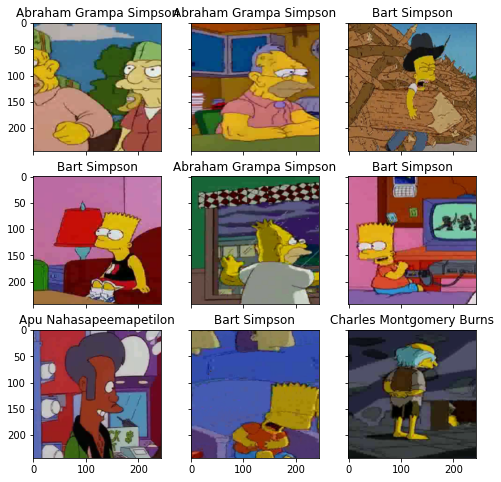

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    print(type(train_loader))
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    print(type(val_files))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

<class '__main__.SimpsonsDataset'>


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.utils.data.dataloader.DataLoader'>
loss 2.755176466964249


epoch:  50%|█████     | 1/2 [01:09<01:09, 69.48s/it]


Epoch 001 train_loss: 2.7552     val_loss 2.1416 train_acc 0.2328 val_acc 0.4253
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.7102792412393815


epoch: 100%|██████████| 2/2 [02:20<00:00, 70.11s/it]


Epoch 002 train_loss: 1.7103     val_loss 1.4325 train_acc 0.5353 val_acc 0.6179


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

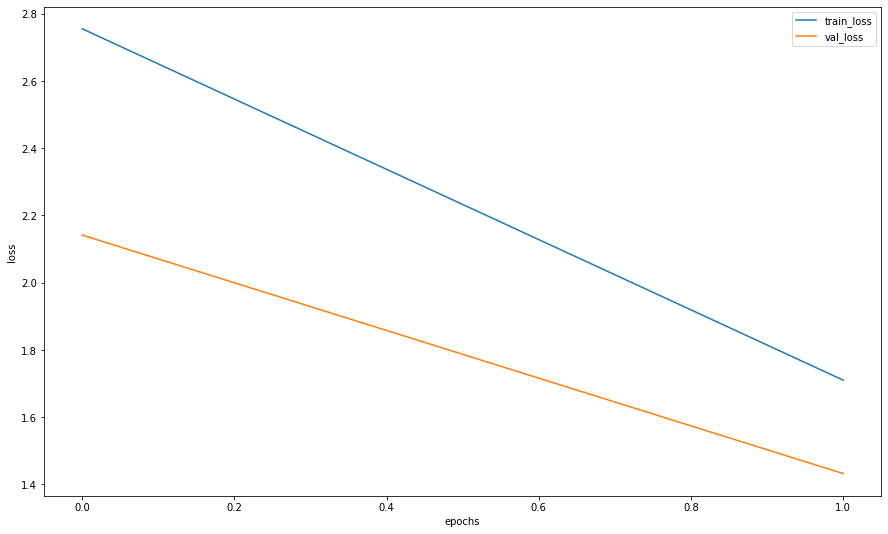

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average = 'micro')


0.35

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

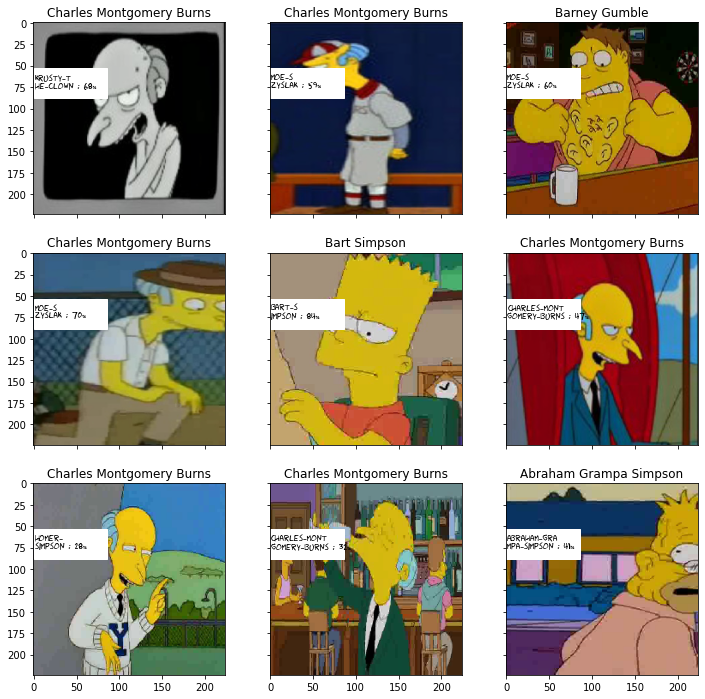

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [ ]:
import pandas as pd
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
cd gdrive/My Drive/simpsons/

/content/gdrive/My Drive/simpsons


In [ ]:
my_submit.to_csv('/content/gdrive/My Drive/simpsons/simple_cnn_baseline.csv', index=False)

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


# Добиваемся улучшения результата



### Улучшения имеющейся сети

Идеи:
* Аугментация;
* добавить Batch Normalization;
* увеличить количество эпох до 9;
* протестировать разные функции активации;
* потьюнить lr с помощью scheduler
* протестировать разные оптимизаторы (Adam, AdamW, SGD, Adagrad).

In [ ]:
import os
from torchvision import datasets

Улучшим класс-обертку с помощью аугментации. Для тренировочных данных добавим трасформер, который с вероятностью 0.5 будет отражать изображение и случайным образом обрезать его до 244 пикселей.

In [ ]:
class SimpsonsDatasetAug(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, transform = None):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.transform = transform

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(244),
            transforms.RandomHorizontalFlip(), #с вероятностью 0.5 отражает изображение
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        val_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(244), #обрезаем до 244 пикселей
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        # x = np.array(x / 255, dtype='float32')
        if self.mode == 'test':
            x = transform(x)
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            if self.mode == 'val':
              x = val_transform(x)
            else:
              x = train_transform(x)
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image

In [ ]:
val_dataset = SimpsonsDatasetAug(val_files, mode='val')

if val_dataset is None:
    val_dataset = SimpsonsDatasetAug(val_files, mode='val')
    
train_dataset = SimpsonsDatasetAug(train_files, mode='train')

Добавим Batch Normalization перед функциями активации.

In [ ]:
class SimpleCnnBatchNorm(nn.Module):
  
    def __init__(self, n_classes, activation):
        super(SimpleCnnBatchNorm, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            activation,
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            activation,
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            activation,
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            activation,
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            activation,
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

Функция для отрисовки процесса обучения моделей:

In [ ]:
def plot_training(history):
    train_losses = [elem[0] for elem in history]
    train_accuracies = [elem[1] for elem in history]
    valid_losses = [elem[2] for elem in history]
    valid_accuracies = [elem[3].item() for elem in history]

    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel('epoch')
    plt.plot(train_losses, label='train_loss')
    plt.plot(valid_losses, label='valid_loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel('epoch')
    plt.plot(valid_accuracies, label='valid accuracy')
    plt.plot(train_accuracies, label='train accuracy')
    plt.legend()

In [ ]:
from torch.optim import lr_scheduler

In [ ]:
from torchvision import datasets, models, transforms

Сделаем новую функцию для обучения моделей. Принципиально она ничем не отличается, здесь просто добавлен шаг шедулера.

In [ ]:
def train_upd(train_files, val_files, scheduler, optimizer, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            scheduler.step()
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return model, history

In [ ]:
n_classes = len(np.unique(train_val_labels))

In [ ]:
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Посмотрим, какая функция активации лучше для нашего набора данных:

In [ ]:
cnn_elu = SimpleCnnBatchNorm(n_classes, nn.ELU()).to(DEVICE)
elu_his = train(train_dataset, val_dataset, model=cnn_elu, epochs=3, batch_size=64)

<class '__main__.SimpsonsDataset2'>


epoch:   0%|          | 0/3 [00:00<?, ?it/s]

<class 'torch.utils.data.dataloader.DataLoader'>
loss 2.6798036443222037


epoch:  33%|███▎      | 1/3 [02:50<05:41, 170.68s/it]


Epoch 001 train_loss: 2.6798     val_loss 1.9372 train_acc 0.2780 val_acc 0.4740
<class 'torch.utils.data.dataloader.DataLoader'>
loss 2.283527843450557


epoch:  67%|██████▋   | 2/3 [05:41<02:50, 170.84s/it]


Epoch 002 train_loss: 2.2835     val_loss 1.6449 train_acc 0.3825 val_acc 0.5493
<class 'torch.utils.data.dataloader.DataLoader'>
loss 2.0694531062065593


epoch: 100%|██████████| 3/3 [08:36<00:00, 172.08s/it]


Epoch 003 train_loss: 2.0695     val_loss 1.4907 train_acc 0.4425 val_acc 0.6039


In [ ]:
cnn_relu = SimpleCnnBatchNorm(n_classes, nn.ReLU()).to(DEVICE)
relu_his = train(train_dataset, val_dataset, model=cnn_relu, epochs=3, batch_size=64)

<class '__main__.SimpsonsDatasetAug'>


epoch:   0%|          | 0/3 [00:00<?, ?it/s]

<class 'torch.utils.data.dataloader.DataLoader'>
loss 2.489775126462864


epoch:  33%|███▎      | 1/3 [01:43<03:27, 103.96s/it]


Epoch 001 train_loss: 2.4898     val_loss 1.6489 train_acc 0.3303 val_acc 0.5627
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.9896780906630835


epoch:  67%|██████▋   | 2/3 [03:26<01:43, 103.21s/it]


Epoch 002 train_loss: 1.9897     val_loss 1.3148 train_acc 0.4570 val_acc 0.6464
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.7400755127248235


epoch: 100%|██████████| 3/3 [05:07<00:00, 102.66s/it]


Epoch 003 train_loss: 1.7401     val_loss 1.1082 train_acc 0.5229 val_acc 0.6905


In [ ]:
cnn_leakyReLU = SimpleCnnBatchNorm(n_classes, nn.LeakyReLU()).to(DEVICE)
leaky_relu_his = train(train_dataset, val_dataset, model=cnn_leakyReLU, epochs=3, batch_size=64)

<class '__main__.SimpsonsDataset2'>


epoch:   0%|          | 0/3 [00:00<?, ?it/s]

<class 'torch.utils.data.dataloader.DataLoader'>
loss 2.5181350145486365

Epoch 001 train_loss: 2.5181     val_loss 1.8792 train_acc 0.3247 val_acc 0.5010
<class 'torch.utils.data.dataloader.DataLoader'>
loss 2.0234170355715717

Epoch 002 train_loss: 2.0234     val_loss 1.3698 train_acc 0.4516 val_acc 0.6276
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.7459564930816025

Epoch 003 train_loss: 1.7460     val_loss 1.2255 train_acc 0.5249 val_acc 0.6683


ReLU показала лучшие результаты, поэтому будем использовать ее в качестве функции активации.

### Тестируем оптимизаторы

Теперь сравним оптимизаторы. Будем использовать функцию train_upd с шедулером.

In [ ]:
optims_dict = {}

**Adam**

In [ ]:
cnn_relu_adam = SimpleCnnBatchNorm(n_classes, nn.ReLU()).to(DEVICE)
optim_adam = torch.optim.Adam(cnn_relu_adam.parameters())
scheduler_adam = lr_scheduler.StepLR(optim_adam, step_size = 3, gamma = 0.1)

In [ ]:
cnn_relu_adam, history_adam = train_upd(train_dataset, val_dataset, scheduler_adam, optim_adam, model = cnn_relu_adam, epochs = 9, batch_size = 64)
optims_dict[optim_adam.__class__.__name__] = history_adam

epoch:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'torch.utils.data.dataloader.DataLoader'>
loss 2.634841834627843


epoch:  11%|█         | 1/9 [01:42<13:42, 102.83s/it]


Epoch 001 train_loss: 2.6348     val_loss 1.8160 train_acc 0.2852 val_acc 0.5132
<class 'torch.utils.data.dataloader.DataLoader'>
loss 2.1098210607883208


epoch:  22%|██▏       | 2/9 [03:23<11:51, 101.65s/it]


Epoch 002 train_loss: 2.1098     val_loss 1.4127 train_acc 0.4245 val_acc 0.6162
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.787555924030814


epoch:  33%|███▎      | 3/9 [05:04<10:07, 101.24s/it]


Epoch 003 train_loss: 1.7876     val_loss 1.1843 train_acc 0.5123 val_acc 0.6886
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.507543203230686


epoch:  44%|████▍     | 4/9 [06:43<08:22, 100.49s/it]


Epoch 004 train_loss: 1.5075     val_loss 0.9289 train_acc 0.5855 val_acc 0.7539
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.4211449568207397


epoch:  56%|█████▌    | 5/9 [08:22<06:40, 100.01s/it]


Epoch 005 train_loss: 1.4211     val_loss 0.8995 train_acc 0.6099 val_acc 0.7629
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.4149492233906198


epoch:  67%|██████▋   | 6/9 [10:01<04:58, 99.51s/it]


Epoch 006 train_loss: 1.4149     val_loss 0.8778 train_acc 0.6167 val_acc 0.7675
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.3435854263780709


epoch:  78%|███████▊  | 7/9 [11:41<03:19, 99.64s/it]


Epoch 007 train_loss: 1.3436     val_loss 0.8514 train_acc 0.6311 val_acc 0.7759
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.349797483355887


epoch:  89%|████████▉ | 8/9 [13:19<01:39, 99.20s/it]


Epoch 008 train_loss: 1.3498     val_loss 0.8447 train_acc 0.6323 val_acc 0.7774
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.3544837138980685


epoch: 100%|██████████| 9/9 [14:58<00:00, 99.87s/it]


Epoch 009 train_loss: 1.3545     val_loss 0.8435 train_acc 0.6288 val_acc 0.7818


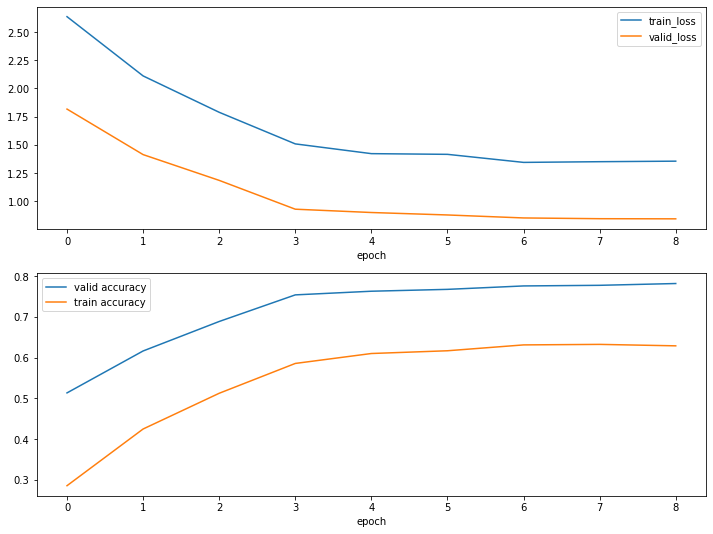

In [ ]:
plot_training(history_adam)

**AdamW**

In [ ]:
cnn_relu_adamW = SimpleCnnBatchNorm(n_classes, nn.ReLU()).to(DEVICE)
optim_adamW = torch.optim.AdamW(cnn_relu_adamW.parameters())
scheduler_adamW = lr_scheduler.StepLR(optim_adamW, step_size = 3, gamma = 0.1)

In [ ]:
cnn_relu_adamW, history_adamW = train_upd(train_dataset, val_dataset, scheduler_adamW, 
                                          optim_adamW, model=cnn_relu_adamW, epochs=9, batch_size=64)
optims_dict[optim_adamW.__class__.__name__] = history_adamW

epoch:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'torch.utils.data.dataloader.DataLoader'>
loss 2.5876112871013923


epoch:  11%|█         | 1/9 [01:43<13:45, 103.19s/it]


Epoch 001 train_loss: 2.5876     val_loss 1.9345 train_acc 0.3094 val_acc 0.4853
<class 'torch.utils.data.dataloader.DataLoader'>
loss 2.117293428118741


epoch:  22%|██▏       | 2/9 [03:27<12:07, 103.88s/it]


Epoch 002 train_loss: 2.1173     val_loss 1.4011 train_acc 0.4256 val_acc 0.6253
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.8277880092647942


epoch:  33%|███▎      | 3/9 [05:08<10:16, 102.67s/it]


Epoch 003 train_loss: 1.8278     val_loss 1.1688 train_acc 0.5014 val_acc 0.6869
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.5400399938724065


epoch:  44%|████▍     | 4/9 [06:49<08:28, 101.76s/it]


Epoch 004 train_loss: 1.5400     val_loss 0.9881 train_acc 0.5823 val_acc 0.7319
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.4530268840572926


epoch:  56%|█████▌    | 5/9 [08:30<06:46, 101.72s/it]


Epoch 005 train_loss: 1.4530     val_loss 0.9419 train_acc 0.6032 val_acc 0.7449
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.4441992828926316


epoch:  67%|██████▋   | 6/9 [10:11<05:03, 101.23s/it]


Epoch 006 train_loss: 1.4442     val_loss 0.9079 train_acc 0.6064 val_acc 0.7568
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.4064782787351915


epoch:  78%|███████▊  | 7/9 [11:51<03:22, 101.01s/it]


Epoch 007 train_loss: 1.4065     val_loss 0.9014 train_acc 0.6196 val_acc 0.7583
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.3944464080219352


epoch:  89%|████████▉ | 8/9 [13:34<01:41, 101.61s/it]


Epoch 008 train_loss: 1.3944     val_loss 0.8962 train_acc 0.6153 val_acc 0.7600
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.372602635207803


epoch: 100%|██████████| 9/9 [15:14<00:00, 101.62s/it]


Epoch 009 train_loss: 1.3726     val_loss 0.8875 train_acc 0.6204 val_acc 0.7619


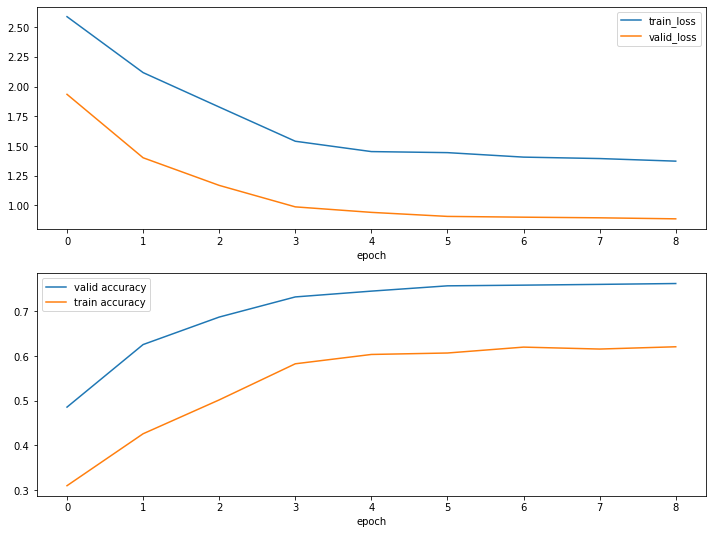

In [ ]:
plot_training(history_adamW)

**SGD**

In [ ]:
cnn_relu_sgd = SimpleCnnBatchNorm(n_classes, nn.ReLU()).to(DEVICE)
optim_sgd = torch.optim.SGD(cnn_relu_sgd.parameters(), lr=0.01, momentum=0.9)
scheduler_SGD = lr_scheduler.StepLR(optim_sgd, step_size = 3, gamma = 0.1)

In [ ]:
cnn_relu_sgd, history_SGD = train_upd(train_dataset, val_dataset, scheduler_SGD, optim_sgd, model = cnn_relu_sgd, epochs = 9, batch_size = 64)
optims_dict[optim_sgd.__class__.__name__] = history_SGD

epoch:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'torch.utils.data.dataloader.DataLoader'>
loss 2.6609175031796726


epoch:  11%|█         | 1/9 [01:38<13:09, 98.74s/it]


Epoch 001 train_loss: 2.6609     val_loss 1.8040 train_acc 0.2998 val_acc 0.5052
<class 'torch.utils.data.dataloader.DataLoader'>
loss 2.158834363648949


epoch:  22%|██▏       | 2/9 [03:16<11:28, 98.30s/it]


Epoch 002 train_loss: 2.1588     val_loss 1.5275 train_acc 0.4140 val_acc 0.5726
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.856434556274431


epoch:  33%|███▎      | 3/9 [04:53<09:44, 97.50s/it]


Epoch 003 train_loss: 1.8564     val_loss 1.1899 train_acc 0.4970 val_acc 0.6763
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.5331443362770905


epoch:  44%|████▍     | 4/9 [06:32<08:09, 98.00s/it]


Epoch 004 train_loss: 1.5331     val_loss 0.9734 train_acc 0.5823 val_acc 0.7358
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.4435934182815289


epoch:  56%|█████▌    | 5/9 [08:09<06:30, 97.72s/it]


Epoch 005 train_loss: 1.4436     val_loss 0.9362 train_acc 0.6049 val_acc 0.7432
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.421030666298286


epoch:  67%|██████▋   | 6/9 [09:46<04:52, 97.42s/it]


Epoch 006 train_loss: 1.4210     val_loss 0.9070 train_acc 0.6086 val_acc 0.7551
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.3855140121759628


epoch:  78%|███████▊  | 7/9 [11:23<03:14, 97.42s/it]


Epoch 007 train_loss: 1.3855     val_loss 0.8796 train_acc 0.6232 val_acc 0.7614
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.3685011072226092


epoch:  89%|████████▉ | 8/9 [13:00<01:37, 97.13s/it]


Epoch 008 train_loss: 1.3685     val_loss 0.8767 train_acc 0.6244 val_acc 0.7637
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.3645923333043801


epoch: 100%|██████████| 9/9 [14:36<00:00, 97.43s/it]


Epoch 009 train_loss: 1.3646     val_loss 0.8720 train_acc 0.6290 val_acc 0.7627


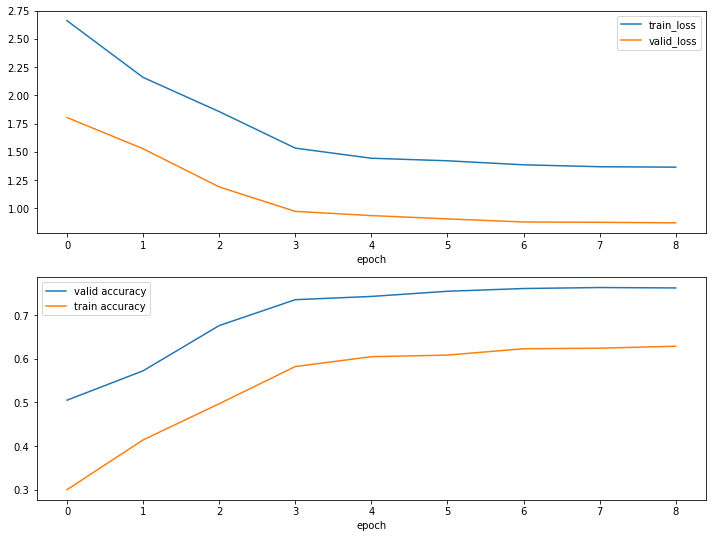

In [ ]:
plot_training(history_SGD)

**Adagrad**

In [ ]:
cnn_relu_adagrad = SimpleCnnBatchNorm(n_classes, nn.ReLU()).to(DEVICE)
optim_adagrad = torch.optim.Adagrad(cnn_relu_adagrad.parameters(), weight_decay = 0.001)
scheduler_adagrad = lr_scheduler.StepLR(optim_adagrad, step_size = 3, gamma = 0.1)

In [ ]:
cnn_relu_adagrad, history_adagrad = train_upd(train_dataset, val_dataset, scheduler_adagrad, optim_adagrad, model = cnn_relu_adagrad, 
                            epochs = 9, batch_size = 64)
optims_dict[optim_adagrad.__class__.__name__] = history_adagrad

epoch:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'torch.utils.data.dataloader.DataLoader'>
loss 2.937738702239349


epoch:  11%|█         | 1/9 [01:45<14:07, 105.95s/it]


Epoch 001 train_loss: 2.9377     val_loss 2.2795 train_acc 0.2695 val_acc 0.3632
<class 'torch.utils.data.dataloader.DataLoader'>
loss 2.2852883775398696


epoch:  22%|██▏       | 2/9 [03:25<11:57, 102.45s/it]


Epoch 002 train_loss: 2.2853     val_loss 1.7653 train_acc 0.3750 val_acc 0.5203
<class 'torch.utils.data.dataloader.DataLoader'>
loss 2.043595748575214


epoch:  33%|███▎      | 3/9 [05:03<10:00, 100.05s/it]


Epoch 003 train_loss: 2.0436     val_loss 1.5458 train_acc 0.4432 val_acc 0.5839
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.836113467338898


epoch:  44%|████▍     | 4/9 [06:39<08:12, 98.52s/it]


Epoch 004 train_loss: 1.8361     val_loss 1.3529 train_acc 0.4993 val_acc 0.6383
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.8219413548884509


epoch:  56%|█████▌    | 5/9 [08:17<06:33, 98.39s/it]


Epoch 005 train_loss: 1.8219     val_loss 1.3323 train_acc 0.5021 val_acc 0.6450
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.7879261712495198


epoch:  67%|██████▋   | 6/9 [09:54<04:54, 98.04s/it]


Epoch 006 train_loss: 1.7879     val_loss 1.3122 train_acc 0.5130 val_acc 0.6481
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.7587991701629453


epoch:  78%|███████▊  | 7/9 [11:32<03:15, 97.76s/it]


Epoch 007 train_loss: 1.7588     val_loss 1.3079 train_acc 0.5187 val_acc 0.6504
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.7757160200860989


epoch:  89%|████████▉ | 8/9 [13:09<01:37, 97.77s/it]


Epoch 008 train_loss: 1.7757     val_loss 1.3063 train_acc 0.5152 val_acc 0.6517
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.757253695273902


epoch: 100%|██████████| 9/9 [14:46<00:00, 98.47s/it]


Epoch 009 train_loss: 1.7573     val_loss 1.3041 train_acc 0.5207 val_acc 0.6536


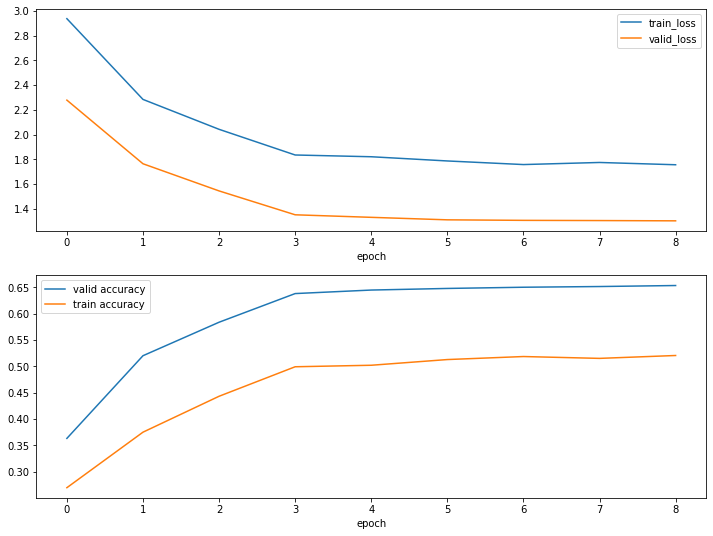

In [ ]:
plot_training(history_adagrad)

Так как Adam показал лучшее значение val_acc на девятой эпохе, будем использовать его в качестве оптимизатора и для AlexNet.

### AlexNet "из коробки"

In [ ]:
model = models.alexnet(pretrained=True) #загружаем веса моделей

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(num_features, n_classes)

use_gpu = torch.cuda.is_available()
# Использовать ли GPU
if use_gpu:
    model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# train_upd(train_dataset, val_dataset, scheduler_adam, optim_adam, model = cnn_relu_adam, epochs = 9, batch_size = 64)
model, history_alexnet = train_upd(train_dataset, val_dataset, exp_lr_scheduler, optimizer_ft, model = model,  epochs = 9, batch_size = 64)

epoch:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.9687362875222507


epoch:  11%|█         | 1/9 [01:45<14:07, 105.93s/it]


Epoch 001 train_loss: 1.9687     val_loss 0.7886 train_acc 0.4747 val_acc 0.7883
<class 'torch.utils.data.dataloader.DataLoader'>
loss 1.0773121832973584


epoch:  22%|██▏       | 2/9 [03:27<12:02, 103.18s/it]


Epoch 002 train_loss: 1.0773     val_loss 0.5675 train_acc 0.7159 val_acc 0.8529
<class 'torch.utils.data.dataloader.DataLoader'>
loss 0.8915826164884122


epoch:  33%|███▎      | 3/9 [05:09<10:16, 102.69s/it]


Epoch 003 train_loss: 0.8916     val_loss 0.4511 train_acc 0.7573 val_acc 0.8848
<class 'torch.utils.data.dataloader.DataLoader'>
loss 0.7804701189849322


epoch:  44%|████▍     | 4/9 [06:52<08:35, 103.08s/it]


Epoch 004 train_loss: 0.7805     val_loss 0.3935 train_acc 0.7865 val_acc 0.9012
<class 'torch.utils.data.dataloader.DataLoader'>
loss 0.713204081612519


epoch:  56%|█████▌    | 5/9 [08:35<06:51, 102.82s/it]


Epoch 005 train_loss: 0.7132     val_loss 0.3893 train_acc 0.8089 val_acc 0.8999
<class 'torch.utils.data.dataloader.DataLoader'>
loss 0.6451504237864897


epoch:  67%|██████▋   | 6/9 [10:15<05:06, 102.07s/it]


Epoch 006 train_loss: 0.6452     val_loss 0.4090 train_acc 0.8277 val_acc 0.8997
<class 'torch.utils.data.dataloader.DataLoader'>
loss 0.6217103766798175


epoch:  78%|███████▊  | 7/9 [11:57<03:23, 101.98s/it]


Epoch 007 train_loss: 0.6217     val_loss 0.3320 train_acc 0.8306 val_acc 0.9199
<class 'torch.utils.data.dataloader.DataLoader'>
loss 0.5543778987513719


epoch:  89%|████████▉ | 8/9 [13:38<01:41, 101.53s/it]


Epoch 008 train_loss: 0.5544     val_loss 0.2978 train_acc 0.8528 val_acc 0.9297
<class 'torch.utils.data.dataloader.DataLoader'>
loss 0.5067792247786963


epoch: 100%|██████████| 9/9 [15:31<00:00, 103.48s/it]


Epoch 009 train_loss: 0.5068     val_loss 0.2914 train_acc 0.8628 val_acc 0.9324


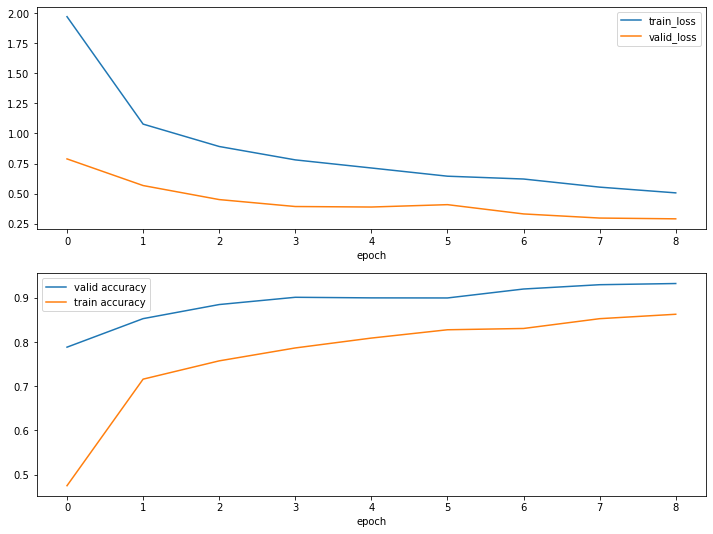

In [ ]:
plot_training(history_alexnet)

In [ ]:
torch.save(model.state_dict(), 'AlexNet_fine_tune.pth')

In [ ]:
model.load_state_dict(torch.load('AlexNet_fine_tune.pth'))

<All keys matched successfully>

In [ ]:
test_dataset = SimpsonsDatasetAug(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


## Submit №2

AlexNet справилась с классификацией лучше, поэтому будем делать сабмит на ее предсказаниях.

In [ ]:
import pandas as pd

In [ ]:
my_submit2 = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit2.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
cd gdrive/My Drive/simpsons/

/content/gdrive/My Drive/simpsons


In [ ]:
my_submit2.to_csv('/content/gdrive/My Drive/simpsons/alexnet_results.csv', index=False)

Результат:

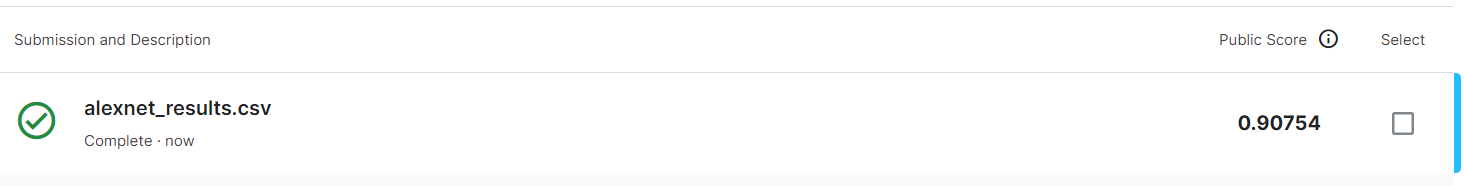